In [2]:
# Importing English to German dataset

!ls
!wget http://www.manythings.org/anki/deu-eng.zip
!unzip deu-eng.zip

Neural Machine Translation.ipynb
--2019-06-14 16:41:23--  http://www.manythings.org/anki/deu-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.109.196, 104.24.108.196
Connecting to www.manythings.org (www.manythings.org)|104.24.109.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4480305 (4.3M) [application/zip]
Saving to: ‘deu-eng.zip’

deu-eng.zip         100%[===================>]   4.27M   596KB/s    in 7.6s    

2019-06-14 16:41:31 (574 KB/s) - ‘deu-eng.zip’ saved [4480305/4480305]

Archive:  deu-eng.zip
  inflating: deu.txt                 
  inflating: _about.txt              


In [4]:
# Examining dataset
# The text file contains English and German translations separated by tab spacing
!head deu.txt

Hi.	Hallo!
Hi.	Grüß Gott!
Run!	Lauf!
Wow!	Potzdonner!
Wow!	Donnerwetter!
Fire!	Feuer!
Help!	Hilfe!
Help!	Zu Hülf!
Stop!	Stopp!
Wait!	Warte!


In [24]:
# Importing modules
import string
import numpy as np
from numpy import array
import pandas as pd
from keras.models import Sequential, load_model
from keras.layers import LSTM, Embedding, Dense, RepeatVector
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [18]:
# Extracting lines from dataset and into array
deu_eng = open('deu.txt', mode='rt', encoding='utf-8')
deu_eng = deu_eng.read()
deu_eng = deu_eng.strip().split('\n')
deu_eng = [i.split('\t') for i in deu_eng]
deu_eng = array(deu_eng)
deu_eng = deu_eng[:50000, :]
print (deu_eng[:5])

[['Hi.' 'Hallo!']
 ['Hi.' 'Grüß Gott!']
 ['Run!' 'Lauf!']
 ['Wow!' 'Potzdonner!']
 ['Wow!' 'Donnerwetter!']]


In [21]:
# Removing punctuation and converting to lowercase
deu_eng[:, 0] = [s.translate((str.maketrans('', '', string.punctuation))) for s in deu_eng[:, 0]]
deu_eng[:, 1] = [s.translate((str.maketrans('', '', string.punctuation))) for s in deu_eng[:, 1]]

for i in range(len(deu_eng)):
    deu_eng[i, 0] = deu_eng[i, 0].lower()
    deu_eng[i, 1] = deu_eng[i, 1].lower()

print (deu_eng[:5])

[['hi' 'hallo']
 ['hi' 'grüß gott']
 ['run' 'lauf']
 ['wow' 'potzdonner']
 ['wow' 'donnerwetter']]


In [23]:
# Tokenizing the lines
def tokenize(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    
    return tokenizer
    
eng_tokenizer = tokenize(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_sequence_length = 8
print ('English vocabulary size: {}'.format(eng_vocab_size))

deu_tokenizer = tokenize(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1
deu_sequence_length = 8
print ('German vocabulary size: {}'.format(deu_vocab_size))

English vocabulary size: 6392
German vocabulary size: 10760


In [31]:
# Convert lines into sequences as input for NMT model
def encode_sequences(tokenizer, sequence_length, lines):
    sequence = tokenizer.texts_to_sequences(lines)
    sequence = pad_sequences(sequence, sequence_length, padding="post") # 0s after the actual sequence
    return sequence

In [30]:
train, test = train_test_split(deu_eng, test_size=.2, random_state=12)

x_train = encode_sequences(deu_tokenizer, deu_sequence_length, train[:, 1])
y_train = encode_sequences(eng_tokenizer, eng_sequence_length, train[:, 0])

x_test = encode_sequences(deu_tokenizer, deu_sequence_length, test[:, 1])
y_test = encode_sequences(eng_tokenizer, eng_sequence_length, test[:, 0])

print (x_train.shape, y_train.shape)
print (x_test.shape, x_test.shape)

(40000, 8) (40000, 8)
(10000, 8) (10000, 8)


In [32]:
def neural_machine_translation(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    
    return model

model = neural_machine_translation(deu_vocab_size, eng_vocab_size, deu_sequence_length, eng_sequence_length, 512)
rms = RMSprop(lr=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=rms)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 8, 512)            5509120   
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 8, 512)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 8, 512)            2099200   
_________________________________________________________________
dense_1 (Dense)              (None, 8, 6392)           3279096   
Total params: 12,986,616
Trainable params: 12,986,616
Non-trainable params: 0
_________________________________________________________________


In [35]:
filename = 'nmt_model.h1'
checkpoint = ModelCheckpoint(filename, monitor="val_loss", verbose=1, save_best_only=True, mode="min")
history = model.fit(x_train, y_train.reshape(y_train.shape[0], y_train.shape[1], 1), epochs=30, batch_size=512, validation_split=0.2, callbacks=[checkpoint])

Train on 32000 samples, validate on 8000 samples
Epoch 1/30
32000/32000 [==============================] - 271s 8ms/step - loss: 3.1834 - val_loss: 2.9820

Epoch 00001: val_loss improved from inf to 2.98200, saving model to nmt_model.h1
Epoch 2/30
32000/32000 [==============================] - 289s 9ms/step - loss: 2.8846 - val_loss: 2.8202

Epoch 00002: val_loss improved from 2.98200 to 2.82023, saving model to nmt_model.h1
Epoch 3/30
32000/32000 [==============================] - 248s 8ms/step - loss: 2.7003 - val_loss: 2.7159

Epoch 00003: val_loss improved from 2.82023 to 2.71590, saving model to nmt_model.h1
Epoch 4/30
32000/32000 [==============================] - 242s 8ms/step - loss: 2.5456 - val_loss: 2.5544

Epoch 00004: val_loss improved from 2.71590 to 2.55437, saving model to nmt_model.h1
Epoch 5/30
32000/32000 [==============================] - 241s 8ms/step - loss: 2.4035 - val_loss: 2.4277

Epoch 00005: val_loss improved from 2.55437 to 2.42772, saving model to nmt_mode

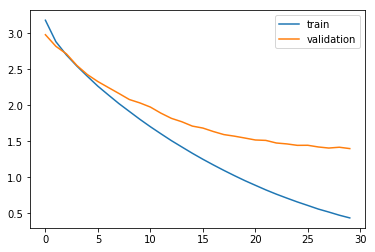

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'validation'])
plt.show()

In [39]:
# Loading model weights
model = load_model('nmt_model.h1')
preds = model.predict_classes(x_test.reshape(x_test.shape[0], x_test.shape[1]))
print (preds[:5])

[[  2  97  49  41  50   0   0   0]
 [  2  94  64   0   0   0   0   0]
 [193  64   9   9   0   0   0   0]
 [  2 113   3   5   0   0   0   0]
 [  1   4  28  54  54   0   0   0]]


In [40]:
def convert_words(n, tokenizer):
    for word, idx in tokenizer.word_index.items():
        if idx == n:
            return word
    return None

In [43]:
pred_texts = []
for i in preds:
    temp = []
    for j in range(len(i)):
        word = convert_words(i[j], eng_tokenizer)
        if j > 0:
            if (word == convert_words(i[j-1], eng_tokenizer)) or (word == None):
                temp.append('')
            else:
                temp.append(word)
        else:
            if (word == None):
                temp.append('')
            else:
                temp.append(word)
                
    pred_texts.append(' '.join(temp))    
    
pred_df = pd.DataFrame({'actual': test[:, 0], 'prediction': pred_texts})

                      actual                 prediction
4097      tom picked mary up         tom sent mary     
8050  do you like this color  do you like this color   
1142    it is out of fashion   its about the corner    
3085     people dont do that            dont  that     
1189         lets start here       lets start here     
1264              he is a dj    hes a tennis person    
3453           im a diabetic       im am geography     
3356    when did that happen     when does it occur    
9895         tom is forceful       tom is stubborn     
6992        youre incredible    theyre incredible      
6977        i hate chemistry       i hate reptiles     
2777   please read that book   please read the book    
846          we all love tom            we all tom     
5676      tom isnt the enemy     tom isnt our enemy    
3935           tom dozed off        tom was asleep     


In [47]:
pred_df.sample(15)

,actual,prediction
1244,we miss you very much,we miss you a lot
9900,tom kept me waiting,tom let me wait
1766,tom was also there,tom was there
6008,i need this job,i need this job
7206,they spotted tom,youve have tom
1261,youre ugly,youre are ugly
1436,tom is a boy scout,tom is adaptable
7131,its my fault,im am to blame this
7049,she made him cry,she made him cry
8070,he knows how to swim,he can swim


In [64]:
# Testing the model on custom text
text = ["The car wouldn't start.", 'Hello. How are you?']
instances = []
for i in range(len(text)):
    temp = []
    for word in text[i].split(' '):
        temp.append(word.translate(str.maketrans('', '', string.punctuation)).lower())
    instances.append(' '.join(temp))
    
instances = eng_tokenizer.texts_to_sequences(instances)
instances = pad_sequences(instances, maxlen=8, padding="post")
print (instances)

pred = model.predict_classes(instances)
preds = []
for i in pred:
    temp = []
    for j in i:
        for word, index in deu_tokenizer.word_index.items():
            if index == j:
                temp.append(word)
    preds.append(' '.join(temp))

print (preds)

[[   7   85  506  267    0    0    0    0]
 [1027   43   17    3    0    0    0    0]]
['schon nicht haus', 'können sie']
